# **Sentiment Analysis for Tweets**


In [ ]:
#!pip install wordcloud

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import warnings
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, learning_curve
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
import tensorflow as tf

In [ ]:
generic_tweets = pd.read_csv('sentiment_analysis.csv')
election_tweets = pd.read_csv('Canadian_elections_2021.csv')

## **Data Cleaning**

In [ ]:
stop_words = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "youre", "youve", "youll", "youd", 'your', 'yours', 'yourself', 
              'yourselves', 'he', 'him', 'his', 'himself', 'she', "shes", 'her', 'hers', 'herself', 'it', "its", 'its', 'itself', 'they', 
              'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "thatll", 'these', 'those', 'am', 
              'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 
              'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 
              'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 
              'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 
              'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 
              'rt']   #Define a list of stop words for data cleaning

In [ ]:
def data_cleaning(df):

  df = df.astype(str).apply(lambda x: x.str.encode('ascii', 'ignore').str.decode('ascii'))    #Remove all the emojis

  df['text'] = df['text'].str.lower()   #Convert all characters to lowercase

  df['hashtags'] = df['text'].str.findall(r'#.*?(?=\s|$)')    #Extract key words with hashtag
  df['at sign'] = df['text'].str.findall(r'@.*?(?=\s|$)')    #Extract key words with at sign
  
  df['text'] = df['text'].replace(r'#\S+', '', regex = True)    #Remove all words with hashtag 
  df['text'] = df['text'].replace(r'@\S+', '', regex = True)    #Remove all words with at sign

  df['text'] = df['text'].replace(r'http\S+', '', regex = True).replace(r'www\S+', '', regex = True)  #Remove all the URLs
  
  df["text"] = df['text'].str.replace('[^\w\s]', '', regex = True)   #Remove all punctuations

  df['text'] = df['text'].apply(lambda x: ' '.join([i for i in x.split() if i not in stop_words]))    #Remove all stop words
  
  return df

In [ ]:
generic_tweets = data_cleaning(generic_tweets)    #Perform data cleaning
election_tweets = data_cleaning(election_tweets)

## **Exploratory analysis**

**Build a function that take a dataframe as input to determine the plotical party of the given tweet**

In [ ]:
party_keywords = {'Liberal': ['trudeau', 'liberal', 'lpc'], 'Conservative': ['otoole', 'conservative', 'cpc'], 
                  'NDP': ['ndp', 'singh', 'jagmeet'], 'PPC': ['ppc', 'rightwing', 'max']}   #Define a set of relevant keywords for each party

def party_determination(df):    #Determine the political party of corresponding tweet

  party_list = []

  for i in range(len(df)):

    count_party = {'Liberal': 0, 'Conservative': 0, 'NDP': 0, 'PPC': 0}   #Count the occurance of keywords for each party
    words = df['text'][i].split(' ')

    for j in party_keywords.keys():
      for k in party_keywords[j]:
        for m in df['hashtags'][i]:   #Search for the keywords in hashtags column
          if k in m:
            count_party[j] += 1
          else:
            continue
        for n in words:   #Search for the keywords in text column
          if k in n:
            count_party[j] += 1
          else:
            continue
        for q in df['at sign'][i]:   #Search for the keywords in at sign column
          if k in q:
            count_party[j] += 1
          else:
            continue
    
    sum = 0
    for j in count_party.values():
      sum += j
      
    if sum == 0:    #If no keywords found, party cannot be determined
      party_list.append('N/A')
    elif all(element == list(count_party.values())[0] for element in list(count_party.values())):   #If the occurances of keywords for each party are identical, determine it with the most popular party
      party_list.append('Liberal')
    else:   #If there is max count of keywords for a party, return this party
      party = max(count_party, key = count_party.get)
      party_list.append(party)

  df['Political Party'] = party_list
  del df['hashtags']
  del df['at sign']

  return df

**Determine the political party of tweet**

In [ ]:
party_determination(election_tweets)

,text,sentiment,negative_reason,Political Party
0,canadian election power grab pm trudeau yes ta...,negative,calling election early,Liberal
1,hope trudeau loses canadian election tomorrow ...,negative,covid,Liberal
2,dear canadians election test progressive wheth...,positive,nan,N/A
3,canadian friends never forget trudeau 2 years ...,negative,calling election early,Liberal
4,sorry voted life election fighting freedoms ca...,positive,nan,PPC
...,...,...,...,...
997,absolutely horrible canada forthcoming electio...,negative,others,N/A
998,trudeau imposes gun control policies utterly f...,negative,gun control,Liberal
999,canada election stolen thugs uneducated goons ...,negative,others,N/A
1000,otoole amends platform gun control questions r...,negative,tell lies,Conservative


**What can you say about the distribution of the political affiliations of the tweets?**

By determining the political party of each tweet, I found that liberal party takes the majority of this dataset, followed with conservative party which has the second largest amount of related tweets. PPC and NDP only have very limited amount of related tweets.

**Build the word cloud for generic tweets**

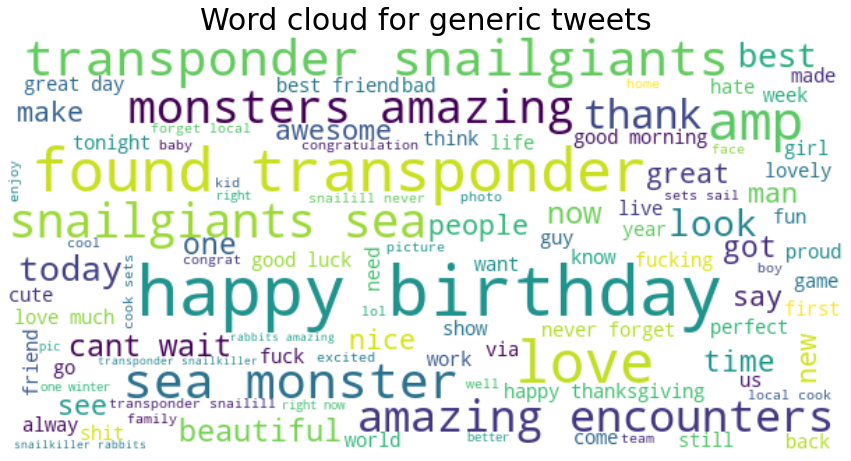

In [ ]:
text_sum_generic = ' '.join(generic_tweets['text'])   #Combine all the tweets text into one string

wordcloud = WordCloud(width = 600, height = 300, max_font_size = 50, max_words = 100, background_color = "white").generate(text_sum_generic)    #Create the word cloud for generic tweets
plt.figure(figsize = (15, 8))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.title('Word cloud for generic tweets', fontsize = 30)
plt.show()

**Build the word cloud for election tweets**

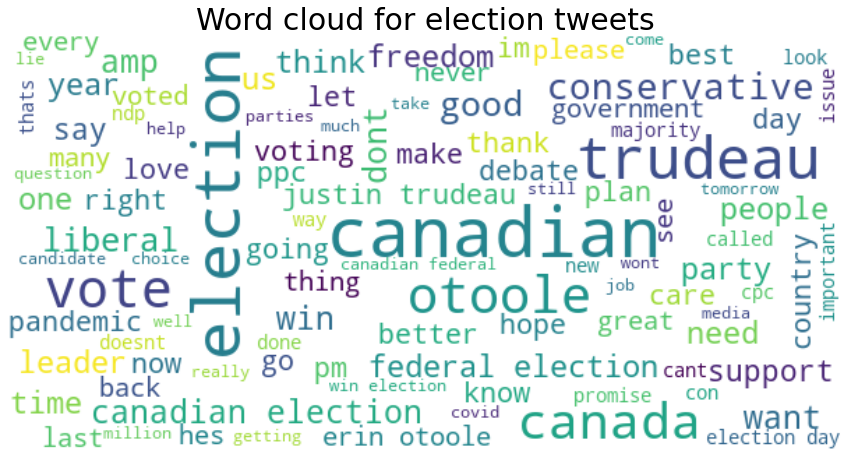

In [ ]:
text_sum_election = ' '.join(election_tweets['text'])   #Combine all the tweets text into one string

wordcloud = WordCloud(width = 600, height = 300, max_font_size = 50, max_words = 100, background_color = "white").generate(text_sum_election)    #Create the word cloud for election tweets
plt.figure(figsize = (15, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word cloud for election tweets", fontsize = 30)
plt.show()

**Discuss your findings**

Based on the word cloud of generic tweets, I found that the most frequent words in the generic tweets are positive, such as "happy birthday", "love", "amazing" and "beautiful". There are also some special words like "snailgiants" and "thanksgiving" which can reflect the most popular things during that certain period of time. By analyzing the word cloud of generic tweets, we can see an image of the trends for that time.

Based on the word cloud of Canadian Election tweets, I found that otoole and trudeau are the two most popular candidates, and liberal party and conservative party are the two most popular parties during the election campaigns. It can also provide us some ideas about the biggest concerns of people during this election by the words like "pandemic", "covid" and "freedom".

## **Sentiment Classification**

### **a) Machine learning models**

**Prepare the data using TF-IDF and split the generic tweets randomly into training data (80%) and test data (20%)**

In [ ]:
vectorizer_tfidf = TfidfVectorizer(stop_words = 'english', max_features = 5000)    #Prepare the data by using TF-IDF
X = vectorizer_tfidf.fit_transform(generic_tweets['text'])

X_train, X_test, y_train, y_test = train_test_split(X, pd.to_numeric(generic_tweets['label']), test_size=0.2, random_state=0)    #Split the training data and test data

**Logistic Regression model**

In [ ]:
warnings.filterwarnings("ignore")

model_logReg = LogisticRegression()   #Define the logistic regression model
model_logReg.fit(X_train, y_train)   #Fit the model
predictions_logReg = model_logReg.predict(X_test)    #Make predictions
score_logReg = accuracy_score(y_test, predictions_logReg)   #Compute the accuracy value
print('The accuracy value for Logistic Regression model is %5f' % score_logReg)

The accuracy value for Logistic Regression model is 0.963181


**k-NN model**

In [ ]:
model_knn = KNeighborsClassifier(n_neighbors = 1)   #Define the knn model
model_knn.fit(X_train, y_train)    #Fit the model
predictions_knn = model_knn.predict(X_test)    #Make predictions
score_knn = accuracy_score(y_test, predictions_knn)   #Compute the accuracy value
print('The accuracy value for k-NN model is %5f' % score_knn)

The accuracy value for k-NN model is 0.851189


**Naive Bayes model**

In [ ]:
model_NB = MultinomialNB()   #Define the Naive Bayes model
model_NB.fit(X_train, y_train)    #Fit the model
predictions_NB = model_NB.predict(X_test)    #Make predictions
score_NB = accuracy_score(y_test, predictions_NB)   #Compute the accuracy value
print('The accuracy value for Naive Bayes model is %5f' % score_NB)

The accuracy value for Naive Bayes model is 0.930813


**SVM model**

In [ ]:
model_SVM = LinearSVC()   #Define the SVM model
model_SVM.fit(X_train, y_train)    #Fit the model
predictions_SVM = model_SVM.predict(X_test)    #Make predictions
score_SVM = accuracy_score(y_test, predictions_SVM)   #Compute the accuracy value
print('The accuracy value for SVM model is %5f' % score_SVM)

The accuracy value for SVM model is 0.963354


**Decision Trees model**

In [ ]:
model_DT = DecisionTreeClassifier(max_depth = 100, random_state=0)   #Define the Decision Trees model
model_DT.fit(X_train, y_train)    #Fit the model
predictions_DT = model_DT.predict(X_test)    #Make predictions
score_DT = accuracy_score(y_test, predictions_DT)   #Compute the accuracy value
print('The accuracy value for Decision Trees model is %5f' % score_DT)

The accuracy value for Decision Trees model is 0.917432


**Random Forest model**

In [ ]:
model_RF = RandomForestClassifier(max_depth = 50, random_state=0)   #Define the Random Forest model
model_RF.fit(X_train, y_train)    #Fit the model
predictions_RF = model_RF.predict(X_test)    #Make predictions
score_RF = accuracy_score(y_test, predictions_RF)   #Compute the accuracy value
print('The accuracy value for Random Forest model is %5f' % score_RF)

The accuracy value for Random Forest model is 0.837135


**XGBoost model**

In [ ]:
model_XGB = XGBClassifier()   #Define the XGBoost model
model_XGB.fit(X_train, y_train)    #Fit the model
predictions_XGB = model_XGB.predict(X_test)    #Make predictions
score_XGB = accuracy_score(y_test, predictions_XGB)   #Compute the accuracy value
print('The accuracy value for XGBoost model is %5f' % score_XGB)

The accuracy value for XGBoost model is 0.848745


**Visualize the accuracy values of seven models**

In [ ]:
accuracy_dict = {'Logistic Regression': score_logReg, 'k-NN': score_knn, 'Naive Bayes': score_NB, 'SVM': score_SVM, 'Decision Trees': score_DT, 'Random Forest': score_RF, 'XGBoost': score_XGB}

accuracy_df = pd.DataFrame(data = accuracy_dict, index = [0])
accuracy_df = pd.melt(accuracy_df)
accuracy_df.columns = ['Model', 'Accuracy']
accuracy_df

,Model,Accuracy
0,Logistic Regression,0.963181
1,k-NN,0.851189
2,Naive Bayes,0.930813
3,SVM,0.963354
4,Decision Trees,0.917432
5,Random Forest,0.837135
6,XGBoost,0.848745


Text(0.5, 1.0, 'Accuracy values of seven models')

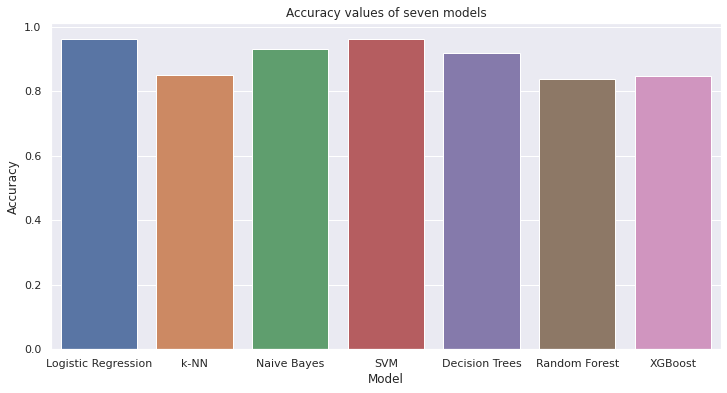

In [ ]:
sns.set(rc = {'figure.figsize':(12,6)})
sns.barplot(data = accuracy_df, x = 'Model', y = 'Accuracy').set_title('Accuracy values of seven models')

### **b) Deep learning model**

**Prepare the data using Bag of Words and split the generic tweets into training data (60%), validation data (20%) and test data (20%)**

In [ ]:
vectorizer_wf = CountVectorizer(analyzer = 'word', stop_words = 'english', max_features = 5000)    #Prepare the training data by using Bag of Words
X = vectorizer_wf.fit_transform(generic_tweets['text'])

X_train, X_test_val, y_train, y_test_val = train_test_split(X, pd.to_numeric(generic_tweets['label']), test_size=0.4, random_state=0)    #Split the training data, validation data and test data
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5, random_state=0)

**Preprocess the data before using the deep learning model**

In [ ]:
def convert_sparse_matrix_to_sparse_tensor(X):    #Define a general function to convert the csr matrix to sparse tensor
    coo = X.tocoo()
    indices = np.mat([coo.row, coo.col]).transpose()
    return tf.SparseTensor(indices, coo.data, coo.shape)

X_train = tf.sparse.reorder(convert_sparse_matrix_to_sparse_tensor(X_train))    #Convert the training data
y_train = tf.convert_to_tensor(y_train)
X_val = tf.sparse.reorder(convert_sparse_matrix_to_sparse_tensor(X_val))    #Convert the validation data
y_val = tf.convert_to_tensor(y_val)
X_test = tf.sparse.reorder(convert_sparse_matrix_to_sparse_tensor(X_test))    #Convert the test data
y_test = tf.convert_to_tensor(y_test)

**Define and Tune the Deep Learning model**

In [ ]:
model_DL = Sequential()

model_DL.add(Dense(50, activation='relu', input_dim = 5000))
model_DL.add(Dense(25, activation='sigmoid'))
model_DL.add(Dense(1, activation='sigmoid'))
model_DL.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

best_accuracy = 0
best_epochs = 0
best_batch_size = 0
for epochs in [1, 2]:
  for batch_size in [10, 100]:
    model_DL.fit(X_train, y_train, epochs = epochs, batch_size = batch_size, verbose = 1)
    _, accuracy = model_DL.evaluate(X_val, y_val)
    if accuracy > best_accuracy:
      best_accuracy = accuracy
      best_epochs = epochs
      best_batch_size = batch_size

print('The best accuracy = %f when epochs = %d and batch size = %d.' %(best_accuracy, best_epochs, best_batch_size))

3440/3440 [==============================] - 5s 1ms/step - loss: 0.0942 - accuracy: 0.9637
Epoch 1/2
33024/33024 [==============================] - 110s 3ms/step - loss: 0.0880 - accuracy: 0.9661
Epoch 2/2
3440/3440 [==============================] - 5s 1ms/step - loss: 0.0938 - accuracy: 0.9650
Epoch 1/2
3303/3303 [==============================] - 22s 6ms/step - loss: 0.0722 - accuracy: 0.9735
Epoch 2/2
3440/3440 [==============================] - 5s 1ms/step - loss: 0.0943 - accuracy: 0.9653
The best accuracy = 0.965261 when epochs = 2 and batch size = 100.


**Evaluate the best model on the test data**

In [ ]:
model_DL.fit(X_train, y_train, epochs = best_epochs, batch_size = best_batch_size, verbose = 1)
_, accuracy = model_DL.evaluate(X_val, y_val)

print('When applying the best deep learning model on the test data, the accuracy is %f' %accuracy)

Epoch 1/2
3303/3303 [==============================] - 15s 4ms/step - loss: 0.0557 - accuracy: 0.9809
Epoch 2/2
3440/3440 [==============================] - 5s 1ms/step - loss: 0.1056 - accuracy: 0.9639
When applying the best deep learning model on the test data, the accuracy is 0.963853


### **c) Evaluate the trained model with the best performance on the Canadian Elections data**

Based on all the accuracy values from 8 models, deep learning model has the best performance, therefore, I choose to use deep learning model to make prediction on the Canadian election data.

In [ ]:
X_election = election_tweets['text']
y_election = election_tweets['sentiment'].replace('negative', 0).replace('positive', 1)

X_election = vectorizer_wf.transform(X_election)    #Prepare the training data by using Bag of Words

X_election = tf.sparse.reorder(convert_sparse_matrix_to_sparse_tensor(X_election))    #Convert the election data
y_election = tf.convert_to_tensor(y_election)

predictions_election = model_DL.predict(X_election) > 0.5
_, accuracy_election = model_DL.evaluate(X_election, y_election)   #Compute the accuracy value
print('The accuracy value with Random Forest model is %5f' % accuracy_election)

32/32 [==============================] - 0s 1ms/step - loss: 1.2544 - accuracy: 0.7156
The accuracy value with Random Forest model is 0.715569


**How well do your predictions match the sentiment labelled in the Canadian elections data?**

Based on the accuracy of this model, it has a decent performance. However, the accuracy when applying it on the Canadian Election data is much less than the accuracy obtained from evaluating on the test data of generic tweets.

### **d) Propose two other evaluation metrics you could use to evaluate the models**

Area Under Curve (AUC) can be used to evaluate the models, since it is used for problems with binary classification. With this metric, it will be better to evaluate the performance of models by visualizing the result with ROC curve.

F1-score is also a good option to use to evaluate the models, since it can measure the accuracy of a test. This metric balance between precision and recall, therefore, it can tell how precise and how robust the model is.

### **e) Visualize the sentiment prediction results and the true sentiment for each of the 4 parties**

**Visualize the sentiment prediction results**

<Figure size 864x432 with 0 Axes>

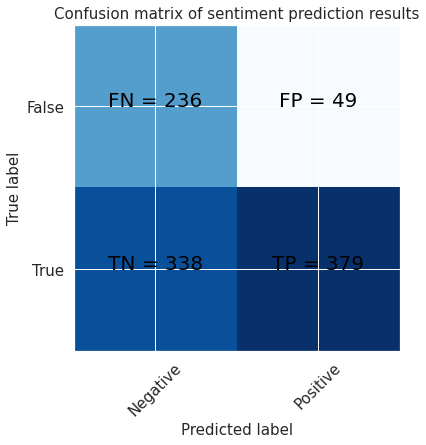

In [ ]:
cm_sentiment = confusion_matrix(y_election, predictions_election)   #Compute the confusion matrix of sentiment prediction
temp = cm_sentiment[0][0]
cm_sentiment[0][0] = cm_sentiment[1][0]
cm_sentiment[1][0] = temp

plt.clf()
plt.figure(figsize=(6, 6))
plt.imshow(cm_sentiment, interpolation='nearest', cmap=plt.cm.Blues)    #Create the visualization of the confusion matrix with different levels of blue
classNames = ['Negative','Positive']
plt.title('Confusion matrix of sentiment prediction results', fontsize = 15)
plt.ylabel('True label', fontsize = 15)
plt.xlabel('Predicted label', fontsize = 15)
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45, fontsize = 15)
plt.yticks(tick_marks, ['False', 'True'], fontsize = 15)
s = [['FN','FP'], ['TN', 'TP']]
thresh = cm_sentiment.max() / 2.
for i in range(2):    #Print the number of FN, TN, FP, TP on the confusion matrix
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm_sentiment[i][j]), fontsize = 20,
                horizontalalignment="center",
                color="black" if cm_sentiment[i, j] > thresh else "black")
plt.show()

**Visualize the true sentiment for each of the 4 parties**

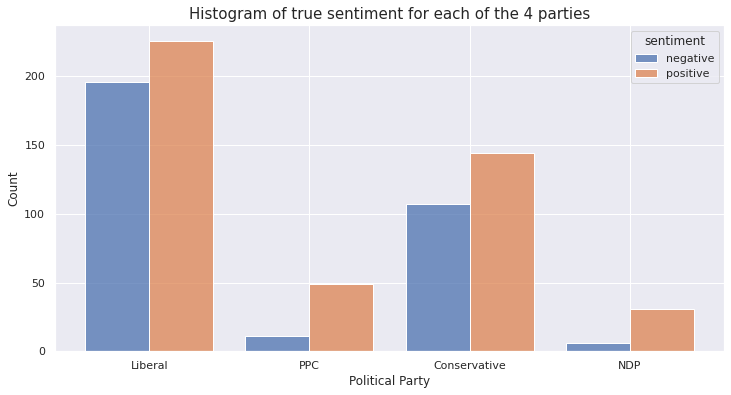

In [ ]:
sns.histplot(data=election_tweets[election_tweets['Political Party'] != 'N/A'], x='Political Party', hue='sentiment', multiple='dodge', shrink=.8)
plt.title('Histogram of true sentiment for each of the 4 parties', fontsize = 15)
plt.show()

**From this model, discuss your findings and whether NLP analytics based on tweets is useful for political parties during election campaigns. Explain how each party is viewed in the public eye based on the sentiment value. Suggest one way you can improve the accuracy of this model.**

Based on the accuracy value and prediction results of this model, we can see that the accuracy is acceptable but it performs much better on a generic tweets dataset. Since this model is trained with the generic tweets dataset, and the features for two datasets may be very different, the overall performance on the election dataset is not good enough. NLP analytics based on tweets should be very useful for political parties during election campaigns, since each party is able to know the actual thought of people by this analysis. However, I do not think this model is very useful for them because of the poor performance. They will be cheated by the inaccurate predictions with all positive sentiment, and wrong decisions will be made. To get a good model for NLP analytics on election tweets, it should be trained with the election tweets data.

Overall, the tweets with positive sentiment are more than the tweets with negative sentiment for every party. For liberal party, it is the most popular one that people talk about during election campaigns. The number of tweets with positive sentiment is slightly more than the tweets with negative sentiment, this means more people like it rather than hating it. Conservative party is also a popular one during the election campaigns, it has the second largest group of people who like it and hate it. Comparing between the tweets with positive sentiment and negative sentiment, we can see that the overall public sentiment against conservative party is positive. For PPC and NDP, these two parties are not popular as liberal party and conservative party, but based on the amount of tweets with positive and negative sentiment, the people who like them are much more than the people who do not. The people generally have good images for PPC and NDP.

Since the dataset we use to fit Bag of Words is generic tweets dataset, the features are all from that dataset as well. When apply it to the election tweets dataset, I presume a number of features will be useless. Therefore, training the model with a dataset of all election tweets can be a great choice to improve the accuracy of this model.

## **Negative Reason Classification**

**Preprocess the data**

In [ ]:
negative_tweets = election_tweets[election_tweets['sentiment'] == 'negative']   #Create a new dataframe with only negative sentiment
X_negative = negative_tweets['text']
y_negative = negative_tweets['negative_reason']

vectorizer_wf_negative = CountVectorizer(stop_words = 'english', max_features = 900)    #Prepare the training data by using Bag of Words
X_negative = vectorizer_wf_negative.fit_transform(X_negative)

X_train_negative, X_test_negative, y_train_negative, y_test_negative = train_test_split(X_negative, y_negative, test_size=0.3, random_state=0)    #Split the training data and test data

**Define and tune the model**

In [ ]:
best_accuracy = 0
best_alpha = 0
best_fit_prior = 0

for alpha in [0, 1, 10]:
  for fit_prior in [True, False]:
    model_NB = MultinomialNB(alpha = alpha, fit_prior = fit_prior)   #Define the Naive Bayes model
    model_NB.fit(X_train_negative, y_train_negative)    #Fit the model
    predictions_NB_negative = model_NB.predict(X_test_negative)    #Make predictions
    score_NB_negative = accuracy_score(y_test_negative, predictions_NB_negative)   #Compute the accuracy value

    if score_NB_negative > best_accuracy:   #Update the parameters and results when the accuracy is the best
      best_accuracy = score_NB_negative
      best_alpha = alpha
      best_fit_prior = fit_prior
      predictions = predictions_NB_negative
    else:
      continue

print('The best accuracy = %f when alpha = %d and fit_prior = %s.' %(best_accuracy, best_alpha, str(best_fit_prior)))

The best accuracy = 0.495726 when alpha = 10 and fit_prior = True.


In [ ]:
print(predictions)

['others' 'others' 'others' 'others' 'others' 'others' 'others'
 'calling election early' 'others' 'others' 'others' 'others'
 'calling election early' 'others' 'calling election early' 'others'
 'others' 'others' 'others' 'others' 'others' 'others'
 'calling election early' 'others' 'others' 'calling election early'
 'others' 'others' 'others' 'others' 'calling election early' 'others'
 'calling election early' 'calling election early' 'others' 'others'
 'calling election early' 'calling election early' 'others' 'others'
 'others' 'others' 'others' 'others' 'others' 'others' 'others' 'others'
 'others' 'others' 'others' 'others' 'others' 'others' 'others'
 'calling election early' 'others' 'calling election early' 'others'
 'others' 'others' 'others' 'others' 'others' 'others' 'others' 'others'
 'calling election early' 'others' 'others' 'others'
 'calling election early' 'others' 'others' 'calling election early'
 'others' 'others' 'others' 'others' 'others' 'others' 'others' 'others

**Provide a few reasons why your model may fail to predict the correct negative reasons. Back up your reasoning with examples from the test sets. Suggest one way you can improve the accuracy of your selected model.**

By observing the accuracy of the best model, it seems not so bad. However, it is also easy to notice that the prediction of negative reasons on the test sets actually fails by printing out the prediction results. We can see that almost all of the predictions are "others" and "calling election early" which are the two largest categories in the negative reasons. 

There are multiple reasons that cause the model fails to predict the correct negative reasons. Firstly, the dataset of Canadian elections tweets is already very limited, and we still have to make it smaller by deleting the tweets data with positive sentiment. After the data processing, all the data left for training and testing is only several hundreds of tweets. Secondly, along with the limited training data, there are too many categories. The dataset is also unbalanced, a few targets take the absolute majority of it, this makes it more difficult to predict for the minority of categories which means the prediction will only focus on those large categories. Therefore, it is basicaly not possible to train a good multi-class classification model with this dataset.

One feasible solution that can improve the accuracy of the model is boostrapping the data, it can balance between categories and provide more training data for the model. The accuracy of the model will increase slightly after bootstrapping, in order to actually improve the performance of the model to a higher level, more real data of Canadian election tweets with negative reasons are needed.

## **Discussion**

### **Step1 Data cleaning**

Data cleaning is a procedure that removes all the irrelevant content from the datasets. The data_cleaning(df) I build is a general function that works for both generic tweets dataset and Canadian Election tweets dataset. It can remove all emojis, URLs, stop words and punctuations from the dataset. Before removing all the content, it will extract the keywords with hashtag and at sign. It is a critical step since it is able to decide the data for the following model implementations, the final prediction accuracy may be affected by this step.

Pros:


*  This function can remove everything irrelevant. 
*  The keywords can be extracted for the following analysis before being removed.

Cons:


*   The stop words list is set by myself, so it may not cover all the possible stop words.
*   It may take quite long time for a large dataset as input. 





### **Step2 Exploratory analysis**

In this step, I designed a procedure that determines the political party of a given tweet by counting the relevant words in both tweet text and hashtag for each party. A tweet will be determined as related to a certain party when this party has the most key words in this tweet. A word cloud with the most frequent words is created for each dataset, it is able to tell a lot of information so I can make further analysis for that dataset. It is also an important step that provides me with a clearer view of the dataset.

Pro:

*   Word cloud is representative, and it is a good visualization of the whole dataset.

Cons:

*   Deciding the political party only by counting the appearances of certain keywords may not always give a correct result.
*   The related keywords for each party are all decided by myself, so some keywords may be missed.








### **Step3 Sentiment Classification**

This is the main step in the whole project. In the machine learning section, I split the generic tweets dataset and prepared the data with TF-IDF firstly. Then I defined all seven models and trained them with the data that has been preprocessed. Accuracy values are computed on the test data and visualized for all seven models. In the deep learning section, I split the data into 3 parts and prepared them with Bag of Words. Then I trained a deep learning model with training set and tuned epochs and batch size using grid search. After the best model is obtained, I evaluated it on the test data and got a accuracy value. The best model is chosen across all these 8 models and evaluated on the Canadian Election data. Since it is a binary classification problem, I visualized the sentiment prediction results by constructing a graph of confusion matrix. The true sentiment for each of the 4 parties is also visualized by a histogram with 4 parties and 2 types of sentiment.

Pros:


*   After preparing the data with TF-IDF, the data that in the form of sparse matrix is directly used for the following implementation, so the memory is greatly saved.
*   By visualizing the confusion matrix, the sentiment prediction results are more intuitive.

Cons:


*   The k-NN model and deep learning model take too long time.
*   Since all 7 machine models are not tuned for different hyperparameters, the best model may be another one with certain parameters.





### **Step4 Negative Reason Classification**

The Canadian Election data is preprocessed by spliting and using word frequency analysis firstly. Then a naive bayes model is used to train with the data and tune with two hyperparameters. Since it is a multi-class classification problem, the tuning of hyperparameters is very important for improving the accuracy of the model.

Pro:


*   Naive Bayes is a great algorithm for multi-class classification, it has better performance compared with other algorithms.

Con:


*   The dataset is too small for the training of a multi-class classification problem.






### **Research question: What can public opinion on Twitter tell us about the Canadian political landscape in 2021**

Liberal party is the most popular party and Justin Trudeau is the strongest candidate. The only party that can compete with liberal party is conservative party with its candidate who is Erin O'Toole.